<a href="https://colab.research.google.com/github/BrendoAires/Biblioteca_.NET/blob/main/Modelo_Previsao_Fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importando bibliotecas
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

In [ ]:
#Importando os dados
#df_original = pd.read_csv('dados_coletados20k.csv')
#df_original = pd.read_csv('dados_coletados80k.csv')

df_original = pd.read_csv('dados_coletados10k.csv')

In [ ]:
df_original.shape

(9517, 24)

In [ ]:
#Avaliando período das observações
inicio = pd.to_datetime(df_original['Data_Contratacao']).dt.date.min()
fim = pd.to_datetime(df_original['Data_Contratacao']).dt.date.max()
print(f"Período de datas entre: {inicio} e {fim}")

Período de datas entre: 2022-07-04 e 2022-12-20


In [ ]:
#Verificando dados nulos
df_original.isnull().sum()

Contrato                               0
Idade                                  0
Sexo                                   0
Valor_Renda                            0
UF_Cliente                             0
Perc_Juros                             0
Prazo_Emprestimo                       0
Data_Contratacao                       0
Prazo_Restante                         0
VL_Emprestimo                          0
VL_Emprestimo_ComJuros                 0
QT_Total_Parcelas_Pagas                0
QT_Total_Parcelas_Pagas_EmDia          0
QT_Total_Parcelas_Pagas_EmAtraso       0
Qt_Renegociacao                        0
Estado_Civil                           0
Escolaridade                        7105
Possui_Patrimonio                      0
VL_Patrimonio                          0
QT_Parcelas_Atraso                     0
QT_Dias_Atraso                      3594
Saldo_Devedor                          0
Total_Pago                             0
Possivel_Fraude                        0
dtype: int64

In [ ]:
#verificando os tipos de variáveis
df_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 24 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Contrato                          9517 non-null   int64  
 1   Idade                             9517 non-null   int64  
 2   Sexo                              9517 non-null   object 
 3   Valor_Renda                       9517 non-null   float64
 4   UF_Cliente                        9517 non-null   object 
 5   Perc_Juros                        9517 non-null   float64
 6   Prazo_Emprestimo                  9517 non-null   int64  
 7   Data_Contratacao                  9517 non-null   object 
 8   Prazo_Restante                    9517 non-null   int64  
 9   VL_Emprestimo                     9517 non-null   float64
 10  VL_Emprestimo_ComJuros            9517 non-null   float64
 11  QT_Total_Parcelas_Pagas           9517 non-null   int64  
 12  QT_Tot

In [ ]:
#total de valores únicos em cada variável
valores_unicos = []
for i in df_original.columns[0:24].tolist():
    print(i, ':', len(df_original[i].astype(str).value_counts()))
    valores_unicos.append(len(df_original[i].astype(str).value_counts()))


Contrato : 9517
Idade : 74
Sexo : 2
Valor_Renda : 855
UF_Cliente : 27
Perc_Juros : 21
Prazo_Emprestimo : 36
Data_Contratacao : 110
Prazo_Restante : 79
VL_Emprestimo : 61
VL_Emprestimo_ComJuros : 61
QT_Total_Parcelas_Pagas : 24
QT_Total_Parcelas_Pagas_EmDia : 24
QT_Total_Parcelas_Pagas_EmAtraso : 15
Qt_Renegociacao : 10
Estado_Civil : 6
Escolaridade : 6
Possui_Patrimonio : 2
VL_Patrimonio : 3
QT_Parcelas_Atraso : 16
QT_Dias_Atraso : 16
Saldo_Devedor : 7654
Total_Pago : 7022
Possivel_Fraude : 2


In [ ]:
#Medidas estatísticas
df_original.describe()

,Contrato,Idade,Valor_Renda,Perc_Juros,Prazo_Emprestimo,Prazo_Restante,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,VL_Patrimonio,QT_Parcelas_Atraso,QT_Dias_Atraso,Saldo_Devedor,Total_Pago
count,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,5923.00,9517.00,9517.00
mean,322078158460.93,38.74,8325.40,19.65,107.43,104.58,81881.89,94164.17,7.89,4.11,1.60,1.24,10.93,5.35,249.79,90560.27,8166.21
std,5434160.86,12.67,121862.06,3.82,62.49,68.57,94138.06,108258.77,5.17,4.04,2.31,1.17,1025.26,5.32,123.22,111050.54,16697.76
min,322068935715.00,6.00,450.00,7.00,15.00,0.00,3500.00,4025.00,0.00,0.00,0.00,0.00,0.00,0.00,11.00,0.00,0.00
25%,322073331715.00,29.00,2300.00,18.00,60.00,51.00,20000.00,23000.00,2.00,1.00,0.00,0.00,0.00,0.00,162.00,18546.85,1202.04
50%,322078461715.00,37.00,3400.00,20.00,80.00,80.00,50000.00,57500.00,9.00,2.00,1.00,1.00,0.00,4.00,284.00,45375.30,3949.91
75%,322082622715.00,46.00,5000.00,22.00,190.00,185.00,100000.00,115000.00,13.00,6.00,2.00,2.00,0.00,11.00,344.00,119721.25,8302.01
max,322087622715.00,91.00,8000080.00,28.00,240.00,227.00,500000.00,575000.00,35.00,35.00,14.00,9.00,100000.00,15.00,435.00,625000.00,396385.00


In [ ]:
#Quantidade de dias em atraso
df_original.groupby(['QT_Dias_Atraso']).size()

QT_Dias_Atraso
11.00     532
41.00     255
71.00     190
103.00    205
133.00    176
162.00    206
194.00    241
225.00    352
251.00    471
284.00    546
315.00    718
344.00    930
376.00    686
406.00    413
435.00      2
dtype: int64

In [ ]:
#Agrupando informações
df_original.groupby(['Sexo']).size()

Sexo
F    3811
M    5706
dtype: int64

In [ ]:
df_original.groupby(['Idade']).size()

Idade
6       1
17      4
18      6
19    109
20    207
21    193
22    173
23    234
24    251
25    253
26    296
27    277
28    280
29    298
30    284
31    281
32    288
33    273
34    310
35    336
36    280
37    262
38    271
39    270
40    264
41    270
42    243
43    233
44    285
45    229
46    208
47    177
48    167
49    172
50    148
51    143
52    118
53    122
54    124
55    124
56     96
57     76
58     90
59     79
60     99
61     71
62     56
63     49
64     54
65     37
66     65
67     39
68     48
69     33
70     27
71     16
72     19
73     16
74     16
75      7
76     12
77      5
78      5
79      3
80      9
81      5
82      3
83      4
84      2
85      5
87      2
88      2
90      2
91      1
dtype: int64

In [ ]:
df_original.groupby('Possivel_Fraude').size()

Possivel_Fraude
Nao    5035
Sim    4482
dtype: int64

In [ ]:
#Ajuste estado civil
df_original['Estado_Civil'] = df_original['Estado_Civil'].replace(['NENHUM'], 'OUTRO')
df_original['Estado_Civil'] = df_original['Estado_Civil'].replace(['UNIÃO ESTAVEL'], 'CASADO (A)')
df_original.groupby('Estado_Civil').size()

Estado_Civil
CASADO (A)     3157
DIVORCIADO      481
OUTRO           652
SOLTEIRO(A)    5087
VIÚVO(A)        140
dtype: int64

In [ ]:
#Criando faixa etária para modelo preditivo
faixa = [0, 21, 30, 40, 50, 60, 100]
labels = ['Até 21 anos', 'De 22 até 30 anos', 'De 31 até 40 anos', 'De 41 até 50 anos', 'De 51 anos até 60 anos', 'Acima de 60 anos']
df_original['Faixa_Etaria'] = pd.cut(df_original['Idade'], bins=faixa, labels=labels)
df_original.groupby('Faixa_Etaria').size()

Faixa_Etaria
Até 21 anos                520
De 22 até 30 anos         2346
De 31 até 40 anos         2835
De 41 até 50 anos         2132
De 51 anos até 60 anos    1071
Acima de 60 anos           613
dtype: int64

In [ ]:
#Criando faixa salarial para modelo preditivo
faixa = [-100, 1000, 2000, 3000, 5000, 10000, 20000,30000,99999999999999999]
labels = ['Até 1k', 'De 1k até 2k', 'De 2k até 3k', 'De 3k até 5k', 'De 5k até 10k', 'De 10k até 20k', 'De 20k até 30k','Acima de 30k']
df_original['Faixa_Salarial'] = pd.cut(df_original['Valor_Renda'], bins=faixa, labels=labels)
df_original.groupby(['Faixa_Salarial']).size()

Faixa_Salarial
Até 1k              19
De 1k até 2k      2012
De 2k até 3k      2522
De 3k até 5k      2646
De 5k até 10k     1574
De 10k até 20k     488
De 20k até 30k     137
Acima de 30k       119
dtype: int64

In [ ]:
#Tratando valores nulos

df_original['QT_Dias_Atraso'] = df_original['QT_Dias_Atraso'].fillna(df_original['QT_Dias_Atraso'].median())

In [ ]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Contrato                          9517 non-null   int64   
 1   Idade                             9517 non-null   int64   
 2   Sexo                              9517 non-null   object  
 3   Valor_Renda                       9517 non-null   float64 
 4   UF_Cliente                        9517 non-null   object  
 5   Perc_Juros                        9517 non-null   float64 
 6   Prazo_Emprestimo                  9517 non-null   int64   
 7   Data_Contratacao                  9517 non-null   object  
 8   Prazo_Restante                    9517 non-null   int64   
 9   VL_Emprestimo                     9517 non-null   float64 
 10  VL_Emprestimo_ComJuros            9517 non-null   float64 
 11  QT_Total_Parcelas_Pagas           9517 non-null   int64 

In [ ]:
#Faixa de dias de atraso
faixa = [-100, 30, 60, 90, 180, 240, 360, 500]
labels = ['Até 30 dias', 'De 31 até 60 dias', 'De 61 até 90 dias', 'De 91 até 180 dias', 'De 181 até 240 dias', 'De 241 até 360 dias', 'Acima de 360']
df_original['Faixa_Dias_Atraso'] = pd.cut(df_original['QT_Dias_Atraso'], bins=faixa, labels=labels)
df_original.groupby(['Faixa_Dias_Atraso']).size()

Faixa_Dias_Atraso
Até 30 dias             532
De 31 até 60 dias       255
De 61 até 90 dias       190
De 91 até 180 dias      587
De 181 até 240 dias     593
De 241 até 360 dias    6259
Acima de 360           1101
dtype: int64

In [ ]:
#Criando faixas de prazo de pagamento
faixa = [0, 60, 120, 200, 720]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df_original['Faixa_Prazo_Emprestimo'] = pd.cut(df_original['Prazo_Emprestimo'], bins=faixa, labels=labels)
df_original.groupby(['Faixa_Prazo_Emprestimo']).size()

Faixa_Prazo_Emprestimo
Até 60 meses            2955
De 61 até 120 meses     3567
De 121 até 200 meses    2814
Acima de 200 meses       181
dtype: int64

In [ ]:
#Criando faixas de prazo de pagamento
faixa = [0, 60, 120, 200, 720]
labels = ['Até 60 meses', 'De 61 até 120 meses', 'De 121 até 200 meses', 'Acima de 200 meses']
df_original['Faixa_Prazo_Restante'] = pd.cut(df_original['Prazo_Emprestimo'], bins=faixa, labels=labels)
df_original.groupby(['Faixa_Prazo_Emprestimo']).size()

Faixa_Prazo_Emprestimo
Até 60 meses            2955
De 61 até 120 meses     3567
De 121 até 200 meses    2814
Acima de 200 meses       181
dtype: int64

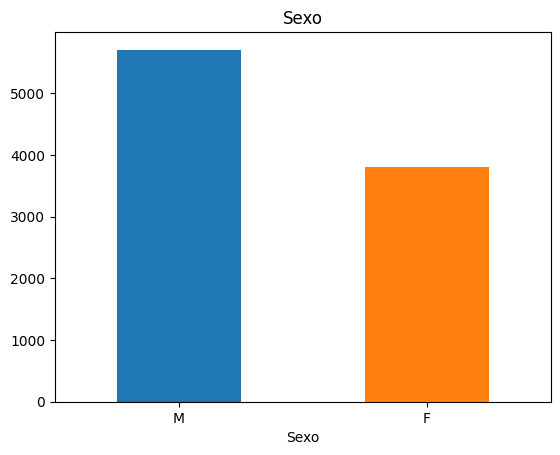

In [ ]:
df_original.Sexo.value_counts().plot(kind='bar',title='Sexo', color=['#1F77B4', '#FF7F0E'], rot=0);

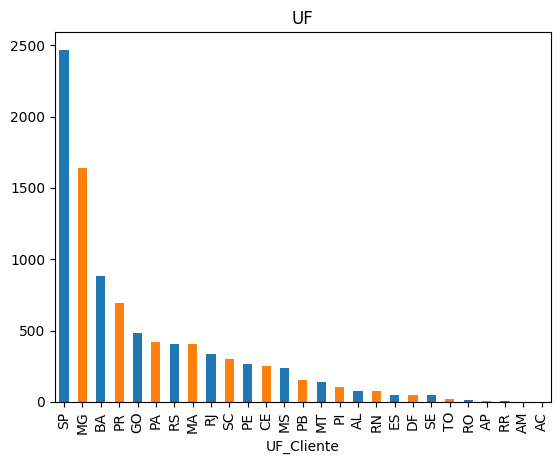

In [ ]:
df_original.UF_Cliente.value_counts().plot(kind='bar',title='UF', color=['#1F77B4', '#FF7F0E']);

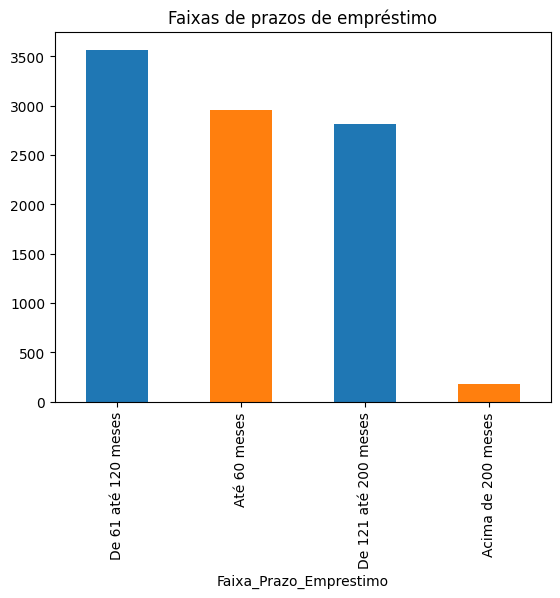

In [ ]:
df_original.Faixa_Prazo_Emprestimo.value_counts().plot(kind='bar',title='Faixas de prazos de empréstimo', color=['#1F77B4', '#FF7F0E']);

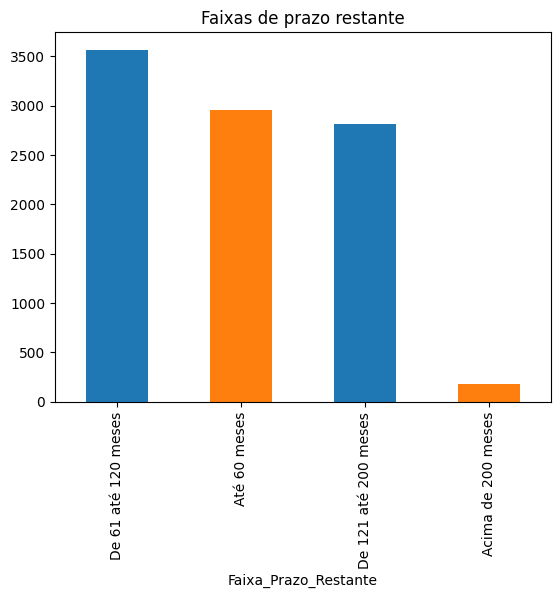

In [ ]:
df_original.Faixa_Prazo_Restante.value_counts().plot(kind='bar', title='Faixas de prazo restante', color=['#1F77B4', '#FF7F0E']);

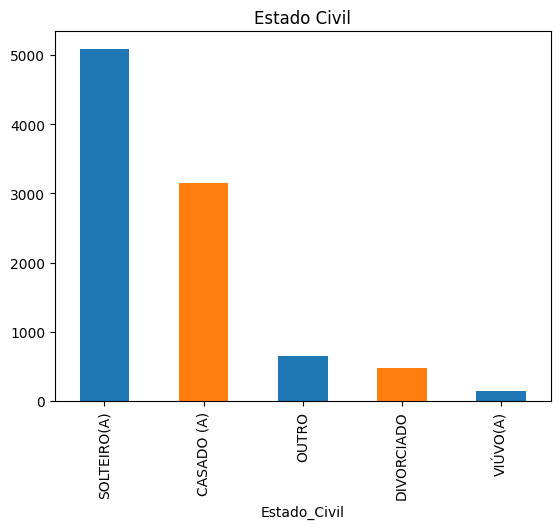

In [ ]:
df_original.Estado_Civil.value_counts().plot(kind='bar', title='Estado Civil', color=['#1F77B4', '#FF7F0E']);

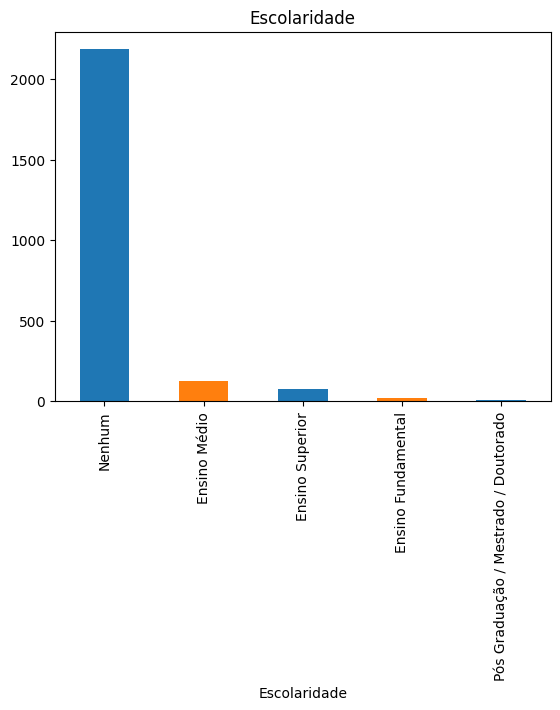

In [ ]:
df_original.Escolaridade.value_counts().plot(kind='bar', title='Escolaridade', color=['#1F77B4', '#FF7F0E']);

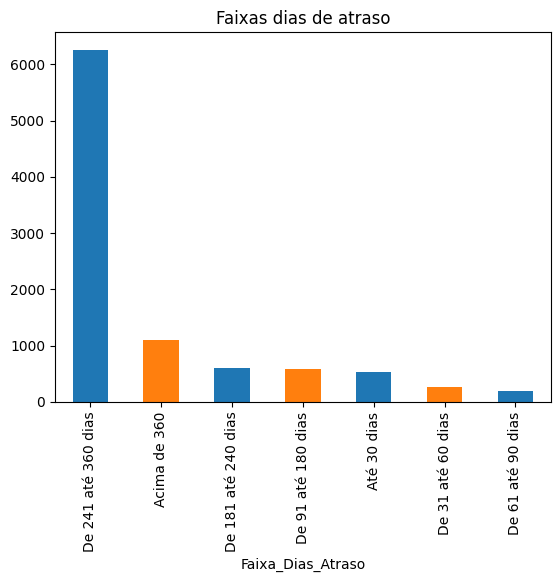

In [ ]:
df_original.Faixa_Dias_Atraso.value_counts().plot(kind='bar', title='Faixas dias de atraso', color=['#1F77B4', '#FF7F0E']);

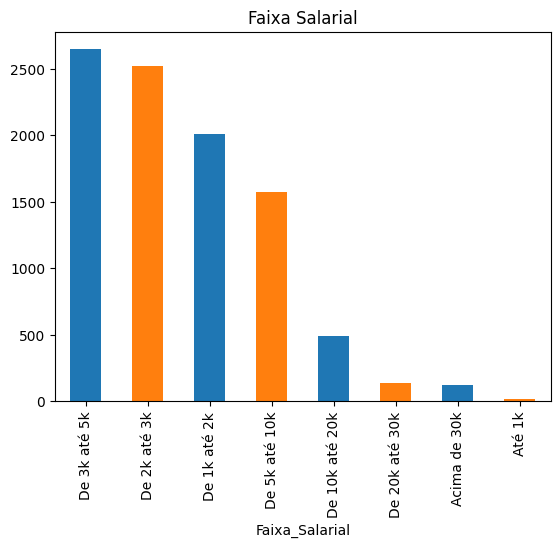

In [ ]:
df_original.Faixa_Salarial.value_counts().plot(kind='bar', title='Faixa Salarial', color=['#1F77B4', '#FF7F0E']);

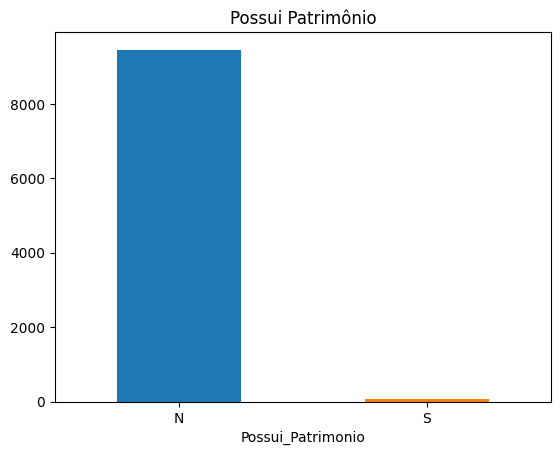

In [ ]:
df_original.Possui_Patrimonio.value_counts().plot(kind='bar', title='Possui Patrimônio', color=['#1F77B4', '#FF7F0E'], rot=0);

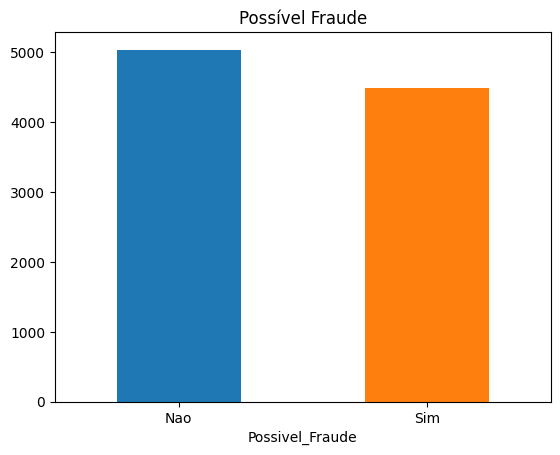

In [ ]:
df_original.Possivel_Fraude.value_counts().plot(kind='bar', title='Possível Fraude', color=['#1F77B4', '#FF7F0E'], rot=0);

In [ ]:
#Após a análise exploratória, algumas colunas serão excluídas do modelo:
#Data_Contratacao,VL_Patrimonio, Escolaridade, Idade, Possui_Patrimonio
#Valor_Renda, Prazo_Emprestimo, QT_Dias_Atraso, Prazo_Restante

columns = ['Sexo','UF_Cliente', 'Perc_Juros',
       'VL_Emprestimo', 'VL_Emprestimo_ComJuros', 'QT_Total_Parcelas_Pagas',
       'QT_Total_Parcelas_Pagas_EmDia', 'QT_Total_Parcelas_Pagas_EmAtraso',
       'Qt_Renegociacao', 'Estado_Civil', 'Faixa_Etaria',
       'QT_Parcelas_Atraso',
       'Saldo_Devedor', 'Total_Pago', 'Faixa_Dias_Atraso',
       'Faixa_Prazo_Emprestimo', 'Faixa_Prazo_Restante', 'Faixa_Salarial','Possivel_Fraude',]

df_dados = pd.DataFrame(df_original, columns=columns)
df_dados.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Faixa_Etaria,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Dias_Atraso,Faixa_Prazo_Emprestimo,Faixa_Prazo_Restante,Faixa_Salarial,Possivel_Fraude
0,M,SP,23.00,80000.00,92000.00,15,9,1,0,DIVORCIADO,De 41 até 50 anos,0,91759.97,7717.08,De 241 até 360 dias,De 121 até 200 meses,De 121 até 200 meses,De 5k até 10k,Nao
1,M,MG,20.00,50000.00,57500.00,10,10,0,0,SOLTEIRO(A),De 22 até 30 anos,4,53981.18,6756.59,De 91 até 180 dias,De 61 até 120 meses,De 61 até 120 meses,De 1k até 2k,Nao
2,M,BA,18.00,100000.00,115000.00,15,5,1,0,CASADO (A),De 31 até 40 anos,0,101150.02,17929.06,De 241 até 360 dias,De 61 até 120 meses,De 61 até 120 meses,De 3k até 5k,Nao
3,M,MG,20.00,30000.00,34500.00,1,1,0,0,SOLTEIRO(A),Até 21 anos,13,36208.10,369.10,Acima de 360,De 61 até 120 meses,De 61 até 120 meses,De 1k até 2k,Sim
4,M,MG,20.00,60000.00,69000.00,16,16,0,0,CASADO (A),De 51 anos até 60 anos,0,60984.00,11845.24,De 241 até 360 dias,De 61 até 120 meses,De 61 até 120 meses,De 2k até 3k,Nao


In [ ]:
df_dados.shape

(9517, 19)

In [ ]:
df_dados.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Sexo                              9517 non-null   object  
 1   UF_Cliente                        9517 non-null   object  
 2   Perc_Juros                        9517 non-null   float64 
 3   VL_Emprestimo                     9517 non-null   float64 
 4   VL_Emprestimo_ComJuros            9517 non-null   float64 
 5   QT_Total_Parcelas_Pagas           9517 non-null   int64   
 6   QT_Total_Parcelas_Pagas_EmDia     9517 non-null   int64   
 7   QT_Total_Parcelas_Pagas_EmAtraso  9517 non-null   int64   
 8   Qt_Renegociacao                   9517 non-null   int64   
 9   Estado_Civil                      9517 non-null   object  
 10  Faixa_Etaria                      9517 non-null   category
 11  QT_Parcelas_Atraso                9517 non-null   int64 

In [ ]:
#Conferindo se há ainda algum valor nulo
df_dados.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
Faixa_Etaria                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Dias_Atraso                   0
Faixa_Prazo_Emprestimo              0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Possivel_Fraude                     0
dtype: int64

#Análise Exploratória de Variáveis Categóricas

In [ ]:
#Ajuste nos tamanhos dos gráficos
plt.rcParams['figure.figsize'] = [10.00, 4.00]
plt.rcParams['figure.autolayout'] = True

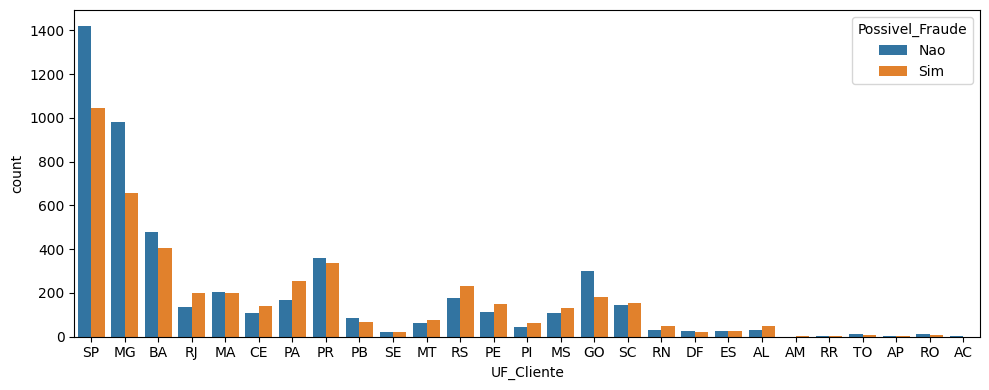

In [ ]:
#Verificando que não ha discrepancias nas variáveis
sns.countplot(data = df_dados, x='UF_Cliente', hue='Possivel_Fraude')
plt.show()

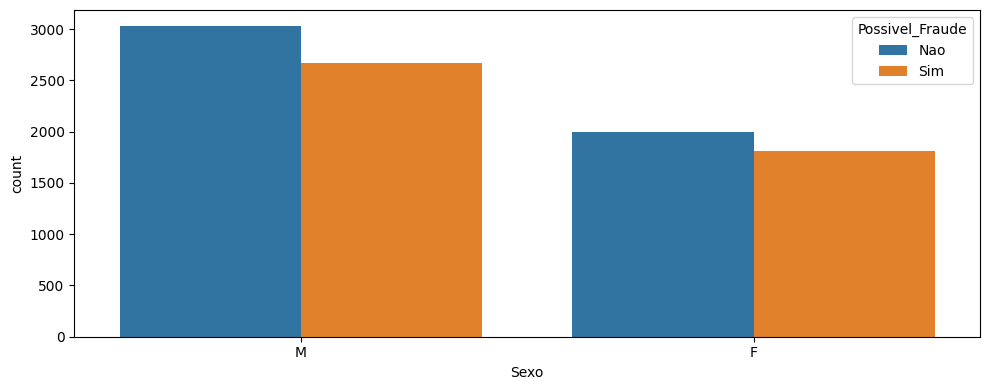

In [ ]:
#Verificando que não ha discrepancias nas variáveis
sns.countplot(data = df_dados, x='Sexo', hue='Possivel_Fraude')
plt.show()

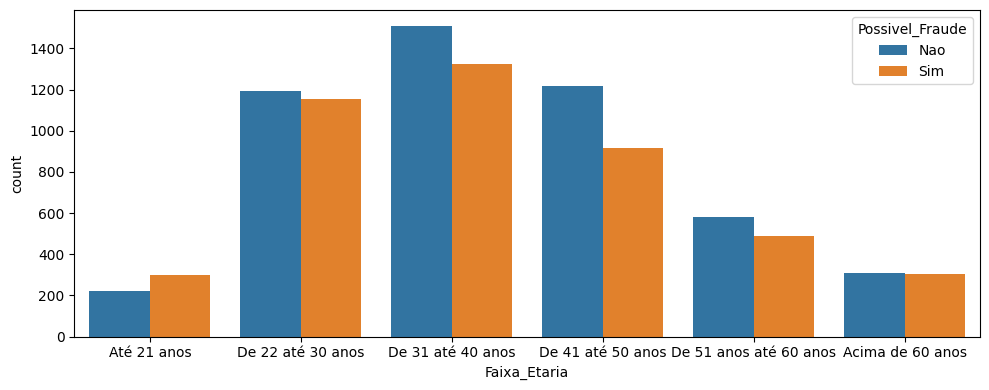

In [ ]:
#Verificando que não ha discrepancias nas variáveis
sns.countplot(data=df_dados, x='Faixa_Etaria', hue='Possivel_Fraude')
plt.show()

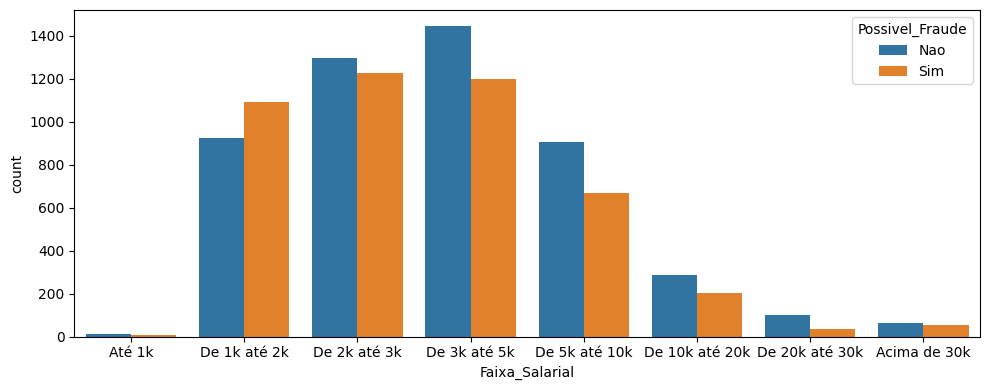

In [ ]:
#Verificando que não ha discrepancias nas variáveis
sns.countplot(data=df_dados, x='Faixa_Salarial', hue='Possivel_Fraude')
plt.show()

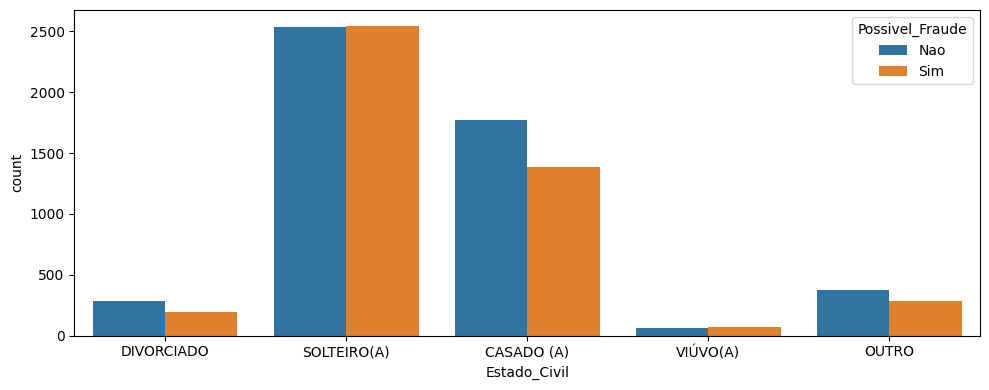

In [ ]:
#Verificando que não ha discrepancias nas variáveis
sns.countplot(data=df_dados, x='Estado_Civil', hue='Possivel_Fraude')
plt.show()

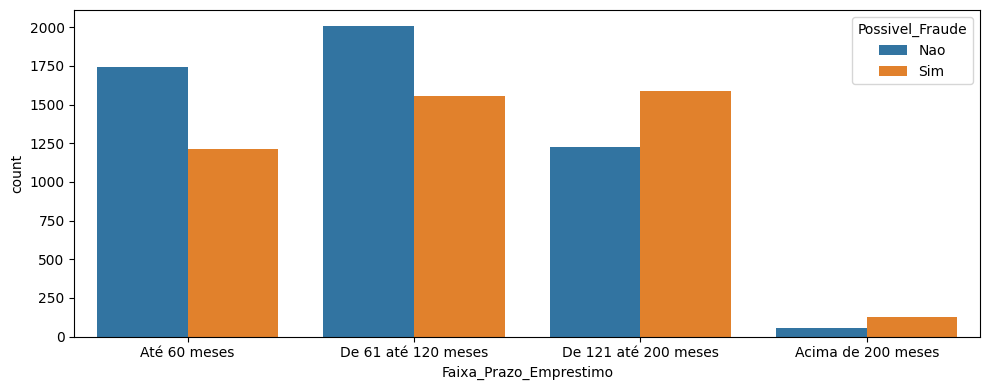

In [ ]:
sns.countplot(data=df_dados, x='Faixa_Prazo_Emprestimo', hue='Possivel_Fraude')
plt.show()

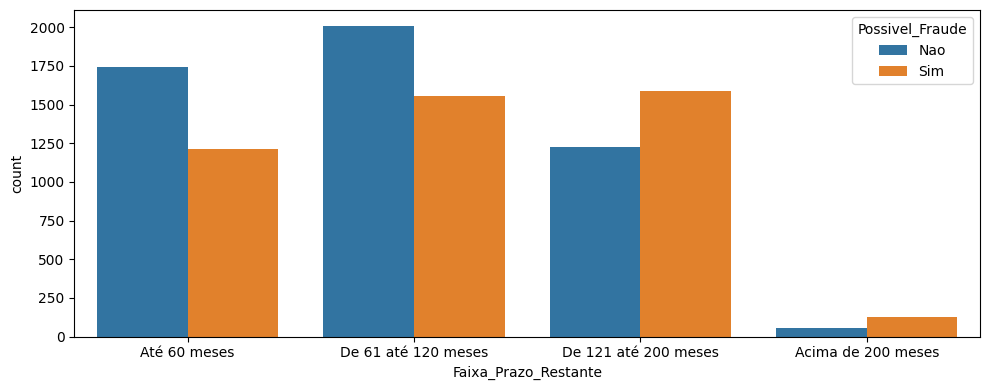

In [ ]:
sns.countplot(data=df_dados, x='Faixa_Prazo_Restante', hue='Possivel_Fraude')
plt.show()

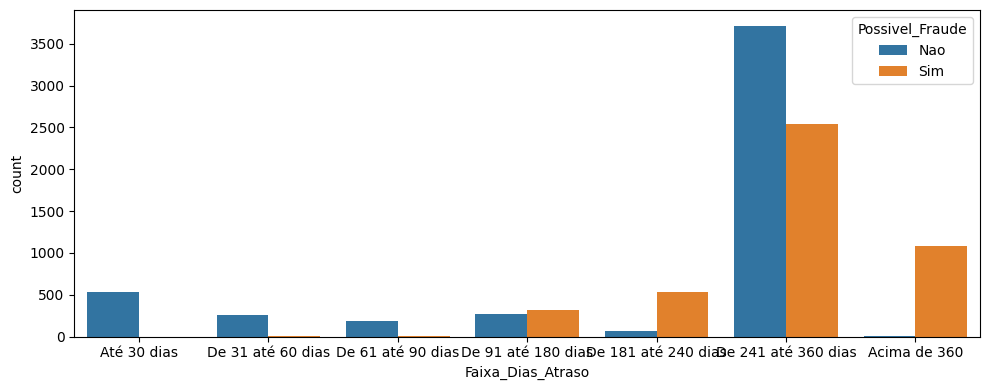

In [ ]:
sns.countplot(data=df_dados, x='Faixa_Dias_Atraso', hue='Possivel_Fraude')
plt.show()

In [ ]:
df_dados.describe()

,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago
count,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00,9517.00
mean,19.65,81881.89,94164.17,7.89,4.11,1.60,1.24,5.35,90560.27,8166.21
std,3.82,94138.06,108258.77,5.17,4.04,2.31,1.17,5.32,111050.54,16697.76
min,7.00,3500.00,4025.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,18.00,20000.00,23000.00,2.00,1.00,0.00,0.00,0.00,18546.85,1202.04
50%,20.00,50000.00,57500.00,9.00,2.00,1.00,1.00,4.00,45375.30,3949.91
75%,22.00,100000.00,115000.00,13.00,6.00,2.00,2.00,11.00,119721.25,8302.01
max,28.00,500000.00,575000.00,35.00,35.00,14.00,9.00,15.00,625000.00,396385.00


In [ ]:
valores_unicos = []
for i in df_dados.columns[0:19].tolist():
  print(i, ':', len(df_dados[i].astype(str).value_counts()))
  valores_unicos.append(len(df_dados[i].astype(str).value_counts()))

Sexo : 2
UF_Cliente : 27
Perc_Juros : 21
VL_Emprestimo : 61
VL_Emprestimo_ComJuros : 61
QT_Total_Parcelas_Pagas : 24
QT_Total_Parcelas_Pagas_EmDia : 24
QT_Total_Parcelas_Pagas_EmAtraso : 15
Qt_Renegociacao : 10
Estado_Civil : 5
Faixa_Etaria : 6
QT_Parcelas_Atraso : 16
Saldo_Devedor : 7654
Total_Pago : 7022
Faixa_Dias_Atraso : 7
Faixa_Prazo_Emprestimo : 4
Faixa_Prazo_Restante : 4
Faixa_Salarial : 8
Possivel_Fraude : 2


#Análise Exploratória Variáveis Numéricas


In [ ]:
#carregar variáveis numéricas
variaveis_numericas = []
for i in df_dados.columns[0:19].tolist():
  if df_dados.dtypes[i] == 'int64' or df_dados.dtypes[i] == 'float64':
    variaveis_numericas.append(i)

In [ ]:
variaveis_numericas

['Perc_Juros',
 'VL_Emprestimo',
 'VL_Emprestimo_ComJuros',
 'QT_Total_Parcelas_Pagas',
 'QT_Total_Parcelas_Pagas_EmDia',
 'QT_Total_Parcelas_Pagas_EmAtraso',
 'Qt_Renegociacao',
 'QT_Parcelas_Atraso',
 'Saldo_Devedor',
 'Total_Pago']

In [ ]:
len(variaveis_numericas)

10

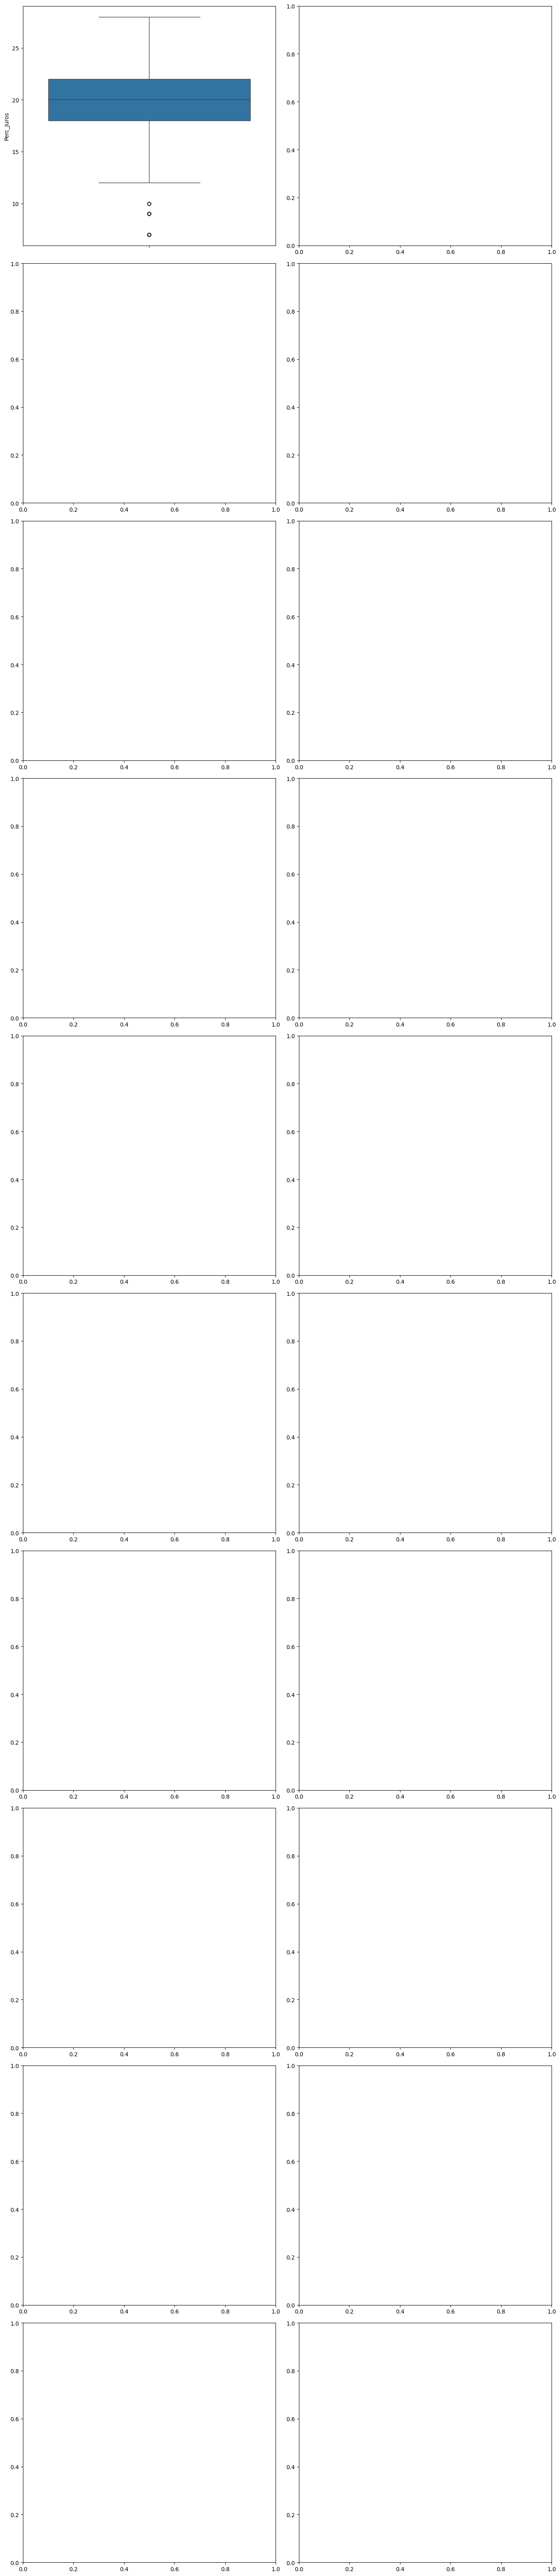

In [ ]:
#Automatizando visualização de possíveis outliers
plt.rcParams['figure.figsize'] = [14.00, 64.00]
plt.rcParams['figure.autolayout'] = True
f, axes = plt.subplots(10, 2) #10 linhas, 2 colunas

linha = 0
coluna = 0
for i in variaveis_numericas:
  sns.boxplot(data=df_dados, y=i, ax=axes[linha][coluna])
  coluna +=1
  if coluna ==2:
    linha +=1
    coluna = 0
  plt.show()

In [ ]:
#Criando lista das variáveis categóricas
variaveis_categoricas = []
for i in df_dados.columns[0:18].tolist():
  if df_dados.dtypes[i] == 'object' or df_dados.dtypes[i] == 'category':
    variaveis_categoricas.append(i)

In [ ]:
variaveis_categoricas

['Sexo',
 'UF_Cliente',
 'Estado_Civil',
 'Faixa_Etaria',
 'Faixa_Dias_Atraso',
 'Faixa_Prazo_Emprestimo',
 'Faixa_Prazo_Restante',
 'Faixa_Salarial']

In [ ]:
#Aplicando One Hot Encoder
lb = LabelEncoder()

for var in variaveis_categoricas:
  df_dados[var] = lb.fit_transform(df_dados[var])

In [ ]:
df_dados.isnull().sum()

Sexo                                0
UF_Cliente                          0
Perc_Juros                          0
VL_Emprestimo                       0
VL_Emprestimo_ComJuros              0
QT_Total_Parcelas_Pagas             0
QT_Total_Parcelas_Pagas_EmDia       0
QT_Total_Parcelas_Pagas_EmAtraso    0
Qt_Renegociacao                     0
Estado_Civil                        0
Faixa_Etaria                        0
QT_Parcelas_Atraso                  0
Saldo_Devedor                       0
Total_Pago                          0
Faixa_Dias_Atraso                   0
Faixa_Prazo_Emprestimo              0
Faixa_Prazo_Restante                0
Faixa_Salarial                      0
Possivel_Fraude                     0
dtype: int64

In [ ]:
df_dados.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Faixa_Etaria,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Dias_Atraso,Faixa_Prazo_Emprestimo,Faixa_Prazo_Restante,Faixa_Salarial,Possivel_Fraude
0,1,25,23.00,80000.00,92000.00,15,9,1,0,1,4,0,91759.97,7717.08,3,2,2,7,Nao
1,1,10,20.00,50000.00,57500.00,10,10,0,0,3,2,4,53981.18,6756.59,6,3,3,3,Nao
2,1,4,18.00,100000.00,115000.00,15,5,1,0,0,3,0,101150.02,17929.06,3,3,3,6,Nao
3,1,10,20.00,30000.00,34500.00,1,1,0,0,3,1,13,36208.10,369.10,0,3,3,3,Sim
4,1,10,20.00,60000.00,69000.00,16,16,0,0,0,5,0,60984.00,11845.24,3,3,3,5,Nao


In [ ]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9517 entries, 0 to 9516
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Sexo                              9517 non-null   int64  
 1   UF_Cliente                        9517 non-null   int64  
 2   Perc_Juros                        9517 non-null   float64
 3   VL_Emprestimo                     9517 non-null   float64
 4   VL_Emprestimo_ComJuros            9517 non-null   float64
 5   QT_Total_Parcelas_Pagas           9517 non-null   int64  
 6   QT_Total_Parcelas_Pagas_EmDia     9517 non-null   int64  
 7   QT_Total_Parcelas_Pagas_EmAtraso  9517 non-null   int64  
 8   Qt_Renegociacao                   9517 non-null   int64  
 9   Estado_Civil                      9517 non-null   int64  
 10  Faixa_Etaria                      9517 non-null   int64  
 11  QT_Parcelas_Atraso                9517 non-null   int64  
 12  Saldo_

In [ ]:
#Visualizando a quantidade da variável target
variavel_target = df_dados.Possivel_Fraude.value_counts()
variavel_target

Possivel_Fraude
Nao    5035
Sim    4482
Name: count, dtype: int64

In [ ]:
#Separando preditoras e target
preditoras = df_dados.iloc[:,0:18]
target = df_dados.iloc[:,18]

In [ ]:
preditoras.head()

,Sexo,UF_Cliente,Perc_Juros,VL_Emprestimo,VL_Emprestimo_ComJuros,QT_Total_Parcelas_Pagas,QT_Total_Parcelas_Pagas_EmDia,QT_Total_Parcelas_Pagas_EmAtraso,Qt_Renegociacao,Estado_Civil,Faixa_Etaria,QT_Parcelas_Atraso,Saldo_Devedor,Total_Pago,Faixa_Dias_Atraso,Faixa_Prazo_Emprestimo,Faixa_Prazo_Restante,Faixa_Salarial
0,1,25,23.00,80000.00,92000.00,15,9,1,0,1,4,0,91759.97,7717.08,3,2,2,7
1,1,10,20.00,50000.00,57500.00,10,10,0,0,3,2,4,53981.18,6756.59,6,3,3,3
2,1,4,18.00,100000.00,115000.00,15,5,1,0,0,3,0,101150.02,17929.06,3,3,3,6
3,1,10,20.00,30000.00,34500.00,1,1,0,0,3,1,13,36208.10,369.10,0,3,3,3
4,1,10,20.00,60000.00,69000.00,16,16,0,0,0,5,0,60984.00,11845.24,3,3,3,5


In [ ]:
target.head()

0    Nao
1    Nao
2    Nao
3    Sim
4    Nao
Name: Possivel_Fraude, dtype: object

In [ ]:
#Seed para reproduzir o mesmo resultado
seed = 100


#Balanceamento SMOTE
balanceador = SMOTE(random_state = seed)

#Aplicando balanceador
preditoras_res, target_res = balanceador.fit_resample(preditoras,target)

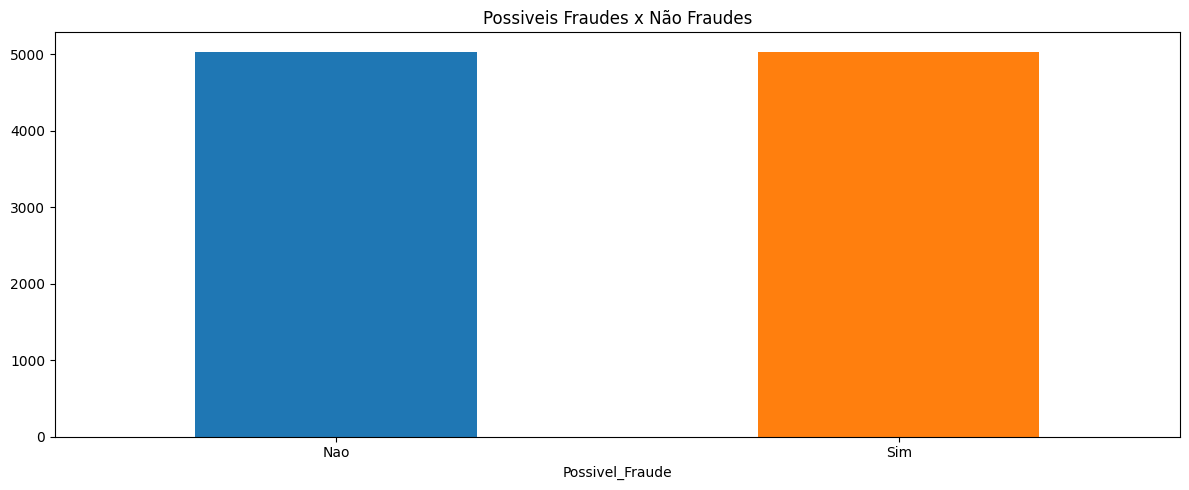

In [ ]:
#Visualizando o balanceamento
plt.rcParams['figure.figsize'] = [12.00, 5.00]
plt.rcParams['figure.autolayout'] = True
target_res.value_counts().plot(kind='bar',title="Possiveis Fraudes x Não Fraudes", color=['#1F77B4', '#FF7F0E'], rot=0);
plt.show()

In [ ]:
#Dividindo a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(preditoras_res, target_res, test_size= 0.2, random_state=42)

####Não normalizar nem padronizar variável preditora

In [ ]:
#Normalização as variáveis
normalize = MinMaxScaler()
X_train_norm = normalize.fit_transform(X_train)
X_test_norm = normalize.fit_transform(X_test)

In [ ]:
#Padronização das variáveis
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.fit_transform(X_test)

In [ ]:
X_train_norm

array([[0.        , 0.38461538, 0.61904762, ..., 1.        , 1.        ,
        0.42857143],
       [1.        , 0.96153846, 0.47619048, ..., 0.66666667, 0.66666667,
        0.71428571],
       [1.        , 0.38461538, 0.52380952, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 0.96153846, 0.71428571, ..., 0.66666667, 0.66666667,
        0.85714286],
       [1.        , 0.88461538, 0.57142857, ..., 0.66666667, 0.66666667,
        1.        ],
       [1.        , 0.96153846, 0.85714286, ..., 1.        , 1.        ,
        0.42857143]])

#Criando e treinando os modelos

##Random Forest

In [ ]:
randomForest = RandomForestClassifier()


In [ ]:
randomForest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
#Valores Hiperparametros
n_estimators = np.array([100,200,300])
max_depth = np.array([10,20])
criterion = np.array(['gini','entropy'])
max_features = np.array(['sqrt','log2', None])
min_samples_split = np.array([1,2,5])
min_samples_leaf = np.array([1,2,3])

#Grid de hiperparametros
grid_parametros = dict(n_estimators = n_estimators,
                       max_depth=max_depth,
                       criterion=criterion,
                       max_features=max_features,
                       min_samples_split=min_samples_split,
                       min_samples_leaf=min_samples_leaf)

#Criando modelo base
randomForest_base = RandomForestClassifier()

#Criando o modelo com Grid de hiperparametros
randomForest = GridSearchCV(randomForest_base, grid_parametros, cv=3, n_jobs=8)

#Treinando os modelos
inicio = time.time()
randomForest.fit(X_train_norm, y_train)
fim = time.time()

#Visualizando os parametros treinados
treinos_rf = pd.DataFrame(randomForest.cv_results_)

#Acuracia em treino
print(f'Acurácia em treinamento: {randomForest.best_score_:.2%}')
print('')
print(f'Hiperparametros Ideais: {randomForest.best_params_}')
print('')
print(f'Número de treinamentos realizados: ', treinos_rf.shape[0])
print('')
print('Tempo de treinamento do modelo: ', round(fim - inicio, 2))

Acurácia em treinamento: 99.34%

Hiperparametros Ideais: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 200}

Número de treinamentos realizados:  324

Tempo de treinamento do modelo:  1007.68


In [ ]:
#Criando o classificador com Random Forest
clf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_depth=20, max_features=None, min_samples_leaf=3, min_samples_split=2, n_jobs=6)

#Construção do modelo
clf = clf.fit(X_train_norm, y_train)

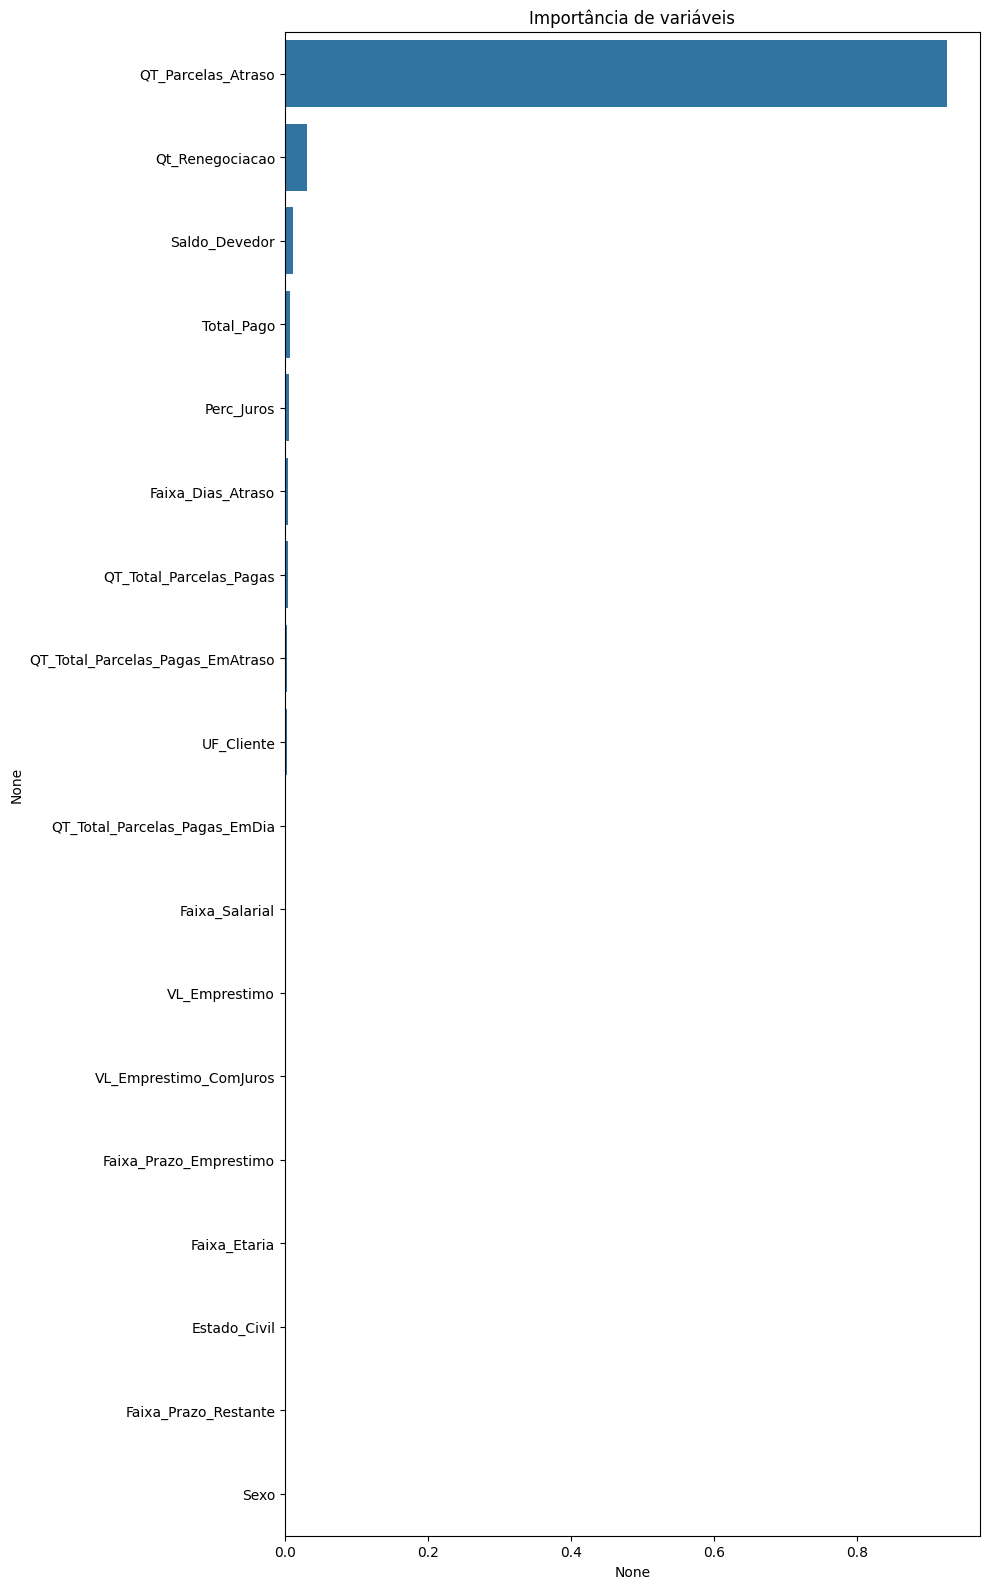

In [ ]:
#Visualizando a importância de cada variável no modelo
plt.rcParams['figure.figsize'] = [10.00, 16.00]
plt.rcParams['figure.autolayout'] = True

importances = pd.Series(data=clf.feature_importances_, index=preditoras.columns)
importances = importances.sort_values(ascending=False)
sns.barplot(x=importances, y=importances.index, orient='h').set_title('Importância de variáveis')
plt.show()


In [ ]:
#Percentual de importância de variáveis
importances.sort_values(ascending=False)

QT_Parcelas_Atraso                 0.93
Qt_Renegociacao                    0.03
Saldo_Devedor                      0.01
Total_Pago                         0.01
Perc_Juros                         0.01
Faixa_Dias_Atraso                  0.00
QT_Total_Parcelas_Pagas            0.00
QT_Total_Parcelas_Pagas_EmAtraso   0.00
UF_Cliente                         0.00
QT_Total_Parcelas_Pagas_EmDia      0.00
Faixa_Salarial                     0.00
VL_Emprestimo                      0.00
VL_Emprestimo_ComJuros             0.00
Faixa_Prazo_Emprestimo             0.00
Faixa_Etaria                       0.00
Estado_Civil                       0.00
Faixa_Prazo_Restante               0.00
Sexo                               0.00
dtype: float64

In [ ]:
#"Simulando os dados de teste"
scores = clf.score(X_train_norm, y_train)
scores

0.9978897715988083

In [ ]:
#"Simulando os dados de teste"
scores = clf.score(X_test_norm, y_test)
scores

0.9870903674280039

In [ ]:
#Dicionário de Métricas e metadados
modelo_rf = {
    'Melhores Parametros' : randomForest.best_params_,
    'Número de Modelos Treinados': treinos_rf.shape[0],
    'Melhor Score': str(round(randomForest.best_score_ * 100,2))+'%'
    }


In [ ]:
modelo_rf

{'Melhores Parametros': {'criterion': 'entropy',
  'max_depth': 20,
  'max_features': None,
  'min_samples_leaf': 3,
  'min_samples_split': 2,
  'n_estimators': 200},
 'Número de Modelos Treinados': 324,
 'Melhor Score': '99.34%'}

##Modelo SVM

In [ ]:
#Construtor do modelo SVM
modelo_svm = SVC()

In [ ]:
#Parâmetros default
modelo_svm.get_params()


{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
#Dicionário de hiperparametros
grid_parametros = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel':['poly', 'rbf', 'sigmoid', 'linear'],
    'degree': [2,3,4,],
    'coef0':[0.5, 1],
    'decision_function_shape':['ovo', 'ovr'],
    'max_iter':[-1,1]
}
svm = GridSearchCV(modelo_svm, grid_parametros, n_jobs=8)

#Treinando o modelo
inicio = time.time()
svm.fit(X_train_norm, y_train)
fim = time.time()

#Obtendo e visualizando os parametros treinados
treinos_svm = pd.DataFrame(svm.cv_results_)

#Acuracia em treino

print(f'Acurácia em treinamento: {svm.best_score_:.2f}')
print('')
print(f'Hiperparametros Ideais: {svm.best_params_}')
print('')
print(f'Número de treinamentos realizados: ' , treinos_svm.shape[0])
print('')
print('Tempo de treinamento do modelo: ', round(fim - inicio, 2))

Acurácia em treinamento: 0.99

Hiperparametros Ideais: {'C': 100, 'coef0': 0.5, 'decision_function_shape': 'ovo', 'degree': 2, 'gamma': 1, 'kernel': 'linear', 'max_iter': -1}

Número de treinamentos realizados:  1536

Tempo de treinamento do modelo:  4156.6


In [ ]:
modelo_svm = {
    'Melhores Parametros' : svm.best_params_,
    'Número de Modelos Treinados': treinos_svm.shape[0],
    'Melhor Score': str(round(svm.best_score_ * 100,2))+'%'
    }


##Modelo KNN


In [ ]:
#Classificador
knn = KNeighborsClassifier()


In [ ]:
#Parametros Default
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [ ]:
#Valores para Grid parametros
n_neighbors = np.array([3,4,5,6,7])
algorithm = np.array(['auto', 'ball_tree', 'kd_tree', 'brute'])
leaf_size = np.array([30,31,32])
metric = np.array(['minkowski', 'euclidean'])

#Grid de hiperparametros
grid_parametros = dict(n_neighbors=n_neighbors,
                       algorithm=algorithm,
                       leaf_size=leaf_size,
                       metric=metric
                       )

knn = GridSearchCV(estimator=knn, param_grid=grid_parametros, n_jobs=8)

#Treinando o modelo
inicio = time.time()
knn.fit(X_train_norm, y_train)
fim = time.time()

#Visualizando os parametros treinados
treinos_knn = pd.DataFrame(knn.cv_results_)

#Acuracia em treino
print(f'Acurácia em treinamento: {knn.best_score_:.2f}')
print('')
print(f'Hiperparametros Ideais: {knn.best_params_}')
print('')
print(f'Número de treinamentos realizados: {treinos_knn.shape[0]}')
print('')
print('Tempo de treinamento do modelo: ', round(fim-inicio,2))

Acurácia em treinamento: 0.97

Hiperparametros Ideais: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 7}

Número de treinamentos realizados: 120

Tempo de treinamento do modelo:  151.77


In [ ]:
modelo_knn = {
    'Melhores Parametros' : knn.best_params_,
    'Número de Modelos Treinados' : treinos_knn.shape[0],
    'Melhor Score' : str(round(knn.best_score_ * 100,2))+'%'
}

In [ ]:
#Gerando um dataframe com os resultados dos modelos para avaliar qual o melhor
resumo = pd.DataFrame(
    {
        'Random Forest':pd.Series(modelo_rf),
        'SVM': pd.Series(modelo_svm),
        'KNN': pd.Series(modelo_knn)
        })

In [ ]:
resumo

,Random Forest,SVM,KNN
Melhores Parametros,"{'criterion': 'entropy', 'max_depth': 20, 'max...","{'C': 100, 'coef0': 0.5, 'decision_function_sh...","{'algorithm': 'auto', 'leaf_size': 30, 'metric..."
Número de Modelos Treinados,324,1536,120
Melhor Score,99.34%,99.06%,97.05%
